<a href="https://colab.research.google.com/github/luciojosep/Portfolio/blob/main/Clase_3_Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis Cuantitativo avanzado**
# **Clase 3: Regresión logística**
# *Lic. Lucio José Pantazis*

## Motivación

La siguiente base "acs_health.Rda" describe datos sobre cobertura de salud en una muestra de estadounidenses residentes en la ciudad de Georgia (disponible en https://github.com/DataScienceForPublicPolicy/diys/tree/main/data ).

### Carga de datos

Para cargar los datos, por el formato ".Rda", es difícil descargarlos directamente desde el link url. Por lo tanto, se puede bajar al disco o cargar el archivo al drive, para que luego el Python pueda interpretarlo.

Además, se requiere un paquete especial para poder leer este tipo de archivos, llamado `pyreadr`.

In [ ]:
# Carga de paquetes
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Una vez instalado el paquete, se puede leer la base de datos guardada en el drive. Para acceder al drive, debo montar el contenido.

In [ ]:
import pyreadr
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

url="/content/drive/MyDrive/Colab Notebooks/Análisis cuantitativo avanzado/Teoría/acs_health.Rda"

result=pyreadr.read_r(url)

Mounted at /content/drive


El formato ".Rda" no carga directamente una base de datos, sino que lo guarda en una lista donde está codificada la base con un nombre (denominado "key"). Por lo tanto, primero conviene inspeccionar el nombre para saber cómo se denomina la base:

In [ ]:
print(result.keys())

odict_keys(['health'])


Como vemos que la base se denomina "health", la cargamos extrayendo de los resultados la variable con ese nombre.

In [ ]:
df = result["health"]

### Inspección de la base

Ya cargada la base, podemos empezar a inspeccionar sus variables y evaluar su estructura.

In [ ]:
df.head()

,id,no.coverage,age,race,sex,wage,cit,mar,schl,esr,puma
0,1,0.0,60,White,Male,66.0,Citizen,Widowed,HS Degree,Employed Civilian,2500
1,2,0.0,44,White,Male,40.0,Citizen,Married,Undergraduate Degree,Employed Civilian,1305
2,3,0.0,40,White,Female,30.0,Citizen,Married,Undergraduate Degree,Employed Civilian,1305
3,4,0.0,76,White,Male,0.0,Citizen,Married,Graduate Degree,Not in Labor Force,2000
4,5,0.0,71,White,Female,0.0,Citizen,Married,HS Degree,Not in Labor Force,2000


Además, veamos qué tipo de datos tienen las variables.




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74805 entries, 0 to 74804
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           74805 non-null  int32   
 1   no.coverage  74805 non-null  float64 
 2   age          74805 non-null  int32   
 3   race         74805 non-null  category
 4   sex          74805 non-null  category
 5   wage         74805 non-null  float64 
 6   cit          74805 non-null  category
 7   mar          74805 non-null  category
 8   schl         74805 non-null  category
 9   esr          74805 non-null  category
 10  puma         74805 non-null  category
dtypes: category(7), float64(2), int32(2)
memory usage: 2.2 MB


Vemos que la base tiene 74805 registros. Entre las variables se encuentran varias ya denominadas como categóricas.


## Variable de respuesta
A partir de esta base, podemos tratar de identificar qué factores influyen sobre tener o
no seguro médico. En la base, esta variable se identifica con “no.coverage”, que está establecida como númerica (`float64`) pero en realidad vemos que es una variable dummy, que sólo toma valores 0 y 1 para identificar si un individuo tiene cobertura médica o no. En este caso, se identifica con un 0 si tiene cobertura y con un 1 si no la tiene.

In [ ]:
print(df["no.coverage"].value_counts())

0.0    61114
1.0    13691
Name: no.coverage, dtype: int64


Vemos que si bien la mayoría de los individuos de la muestra tienen seguro médico, considerando las dificultades socioeconómicas que introduce en la vida cotidiana, sigue siendo un porcentaje alto el de las personas sin seguro médico (cerca del 18%):

In [ ]:
print(df["no.coverage"].value_counts()/df.shape[0]*100)

0.0    81.697747
1.0    18.302253
Name: no.coverage, dtype: float64


Para simplificar un poco algunos análisis, podemos definir una variable `"cobertura"` que en vez de ceros y unos, informe efectivamente si tiene cobertura o no:

In [ ]:
df["cobertura"]=[0]*df.shape[0]
df.loc[df["no.coverage"]==0,"cobertura"]="Con Cobertura"
df.loc[df["no.coverage"]==1,"cobertura"]="Sin Cobertura"
print(df["cobertura"].value_counts()/df.shape[0]*100)

Con Cobertura    81.697747
Sin Cobertura    18.302253
Name: cobertura, dtype: float64


A partir de estos datos, nos puede surgir la siguiente pregunta:

¿Qué variables se vinculan con el hecho de tener o no tener seguro médico?

## Análisis exploratorio de datos

Siempre conviene antes de elegir las variables que consideramos de influencia, ver si hay evidencia que sustente la sospecha. Por lo tanto, vamos a realizar algunos gráficos exploratorios, para lo cual debemos considerar que la variable de respuesta (tener seguro médico o no) es **cualitativa**.

In [ ]:
# Como vamos a graficar, importamos las librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns

## Vínculo con variables cuantitativas

### Boxplots

Primero, veremos cómo se vinculan con la cobertura médica las siguientes variables *cuantitativas*: `"age"` y `"wage"`. La idea es comparar cómo se distribuyen sus valores entre los que tienen seguro médico y no lo tienen. Por lo tanto, podemos comparar sus boxplots

In [ ]:
plt.rcParams['figure.figsize'] = [7.5, 5]

In [ ]:
fig,axes=plt.subplots(1,2)
sns.boxplot(data=df,x="cobertura",y="age",ax=axes[0])
sns.boxplot(data=df,x="cobertura",y="wage",ax=axes[1])
fig.tight_layout()
plt.show()

NameError: ignored

En ambos casos, se puede ver que si bien los valores mínimos y máximos coinciden entre ambas clases, la distribución es distinta, dando nociones de alguna influencia de ambas variables sobre la variable de cobertura.
Ambas variables tienden a tener menores valores entre las personas que no tienen cobertura, ya que las medianas y los terceros cuartiles son menores en ambos casos.

* Lo observado tiene cierta lógica para el caso de la variable `"wage"`, ya que las personas que tengan menor salario, es menos probable que puedan acceder a un seguro médico.
* Sin embargo, la intuición nos falla para la variable `"age"`, ya que se podría pensar que a mayor edad, es más costoso conseguir seguro médico. De todas formas, se puede pensar también que el seguro médico se vuelve más necesario a medida que aumenta la edad y es un costo que se afronta a pesar de las dificultades.



### Stripplots

Otra forma de visualizar estas influencias es con un stripplot, que grafica puntos con una cierta dispersión fija que permite ver dónde hay mayor densidad de puntos.

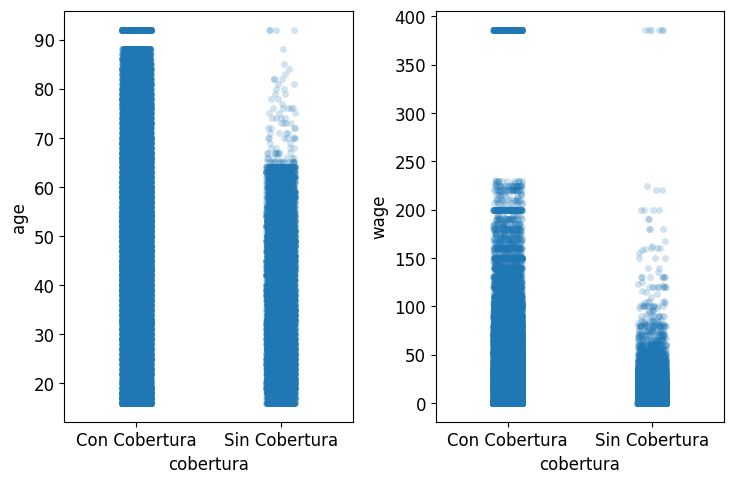

In [ ]:
fig,axes=plt.subplots(1,2)
# Para enfatizar las mayores densidades, se agrega un valor de opacidad (alpha)
sns.stripplot(data=df,x="cobertura",y="age",ax=axes[0],alpha=0.2)
sns.stripplot(data=df,x="cobertura",y="wage",ax=axes[1],alpha=0.2)
fig.tight_layout()
plt.show()

## Vínculo con variables cuantitativas

### Countplots

Ahora vemos cómo se vinculan entre con la cobertura médica las siguientes variables *cualitativas*: `"sex"`, `"cit"`, `"mar"`, `"schl"`, `"esr"` y `"race"`. Podemos comparar los resultados en cada clase utilizando un gráfico de barras o `countplot`:

In [ ]:
labs1=df["sex"].unique()
labs2=df["cit"].unique()
labs3=df["mar"].unique()
labs4=df["schl"].unique()
labs5=df["esr"].unique()
labs6=df["race"].unique()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

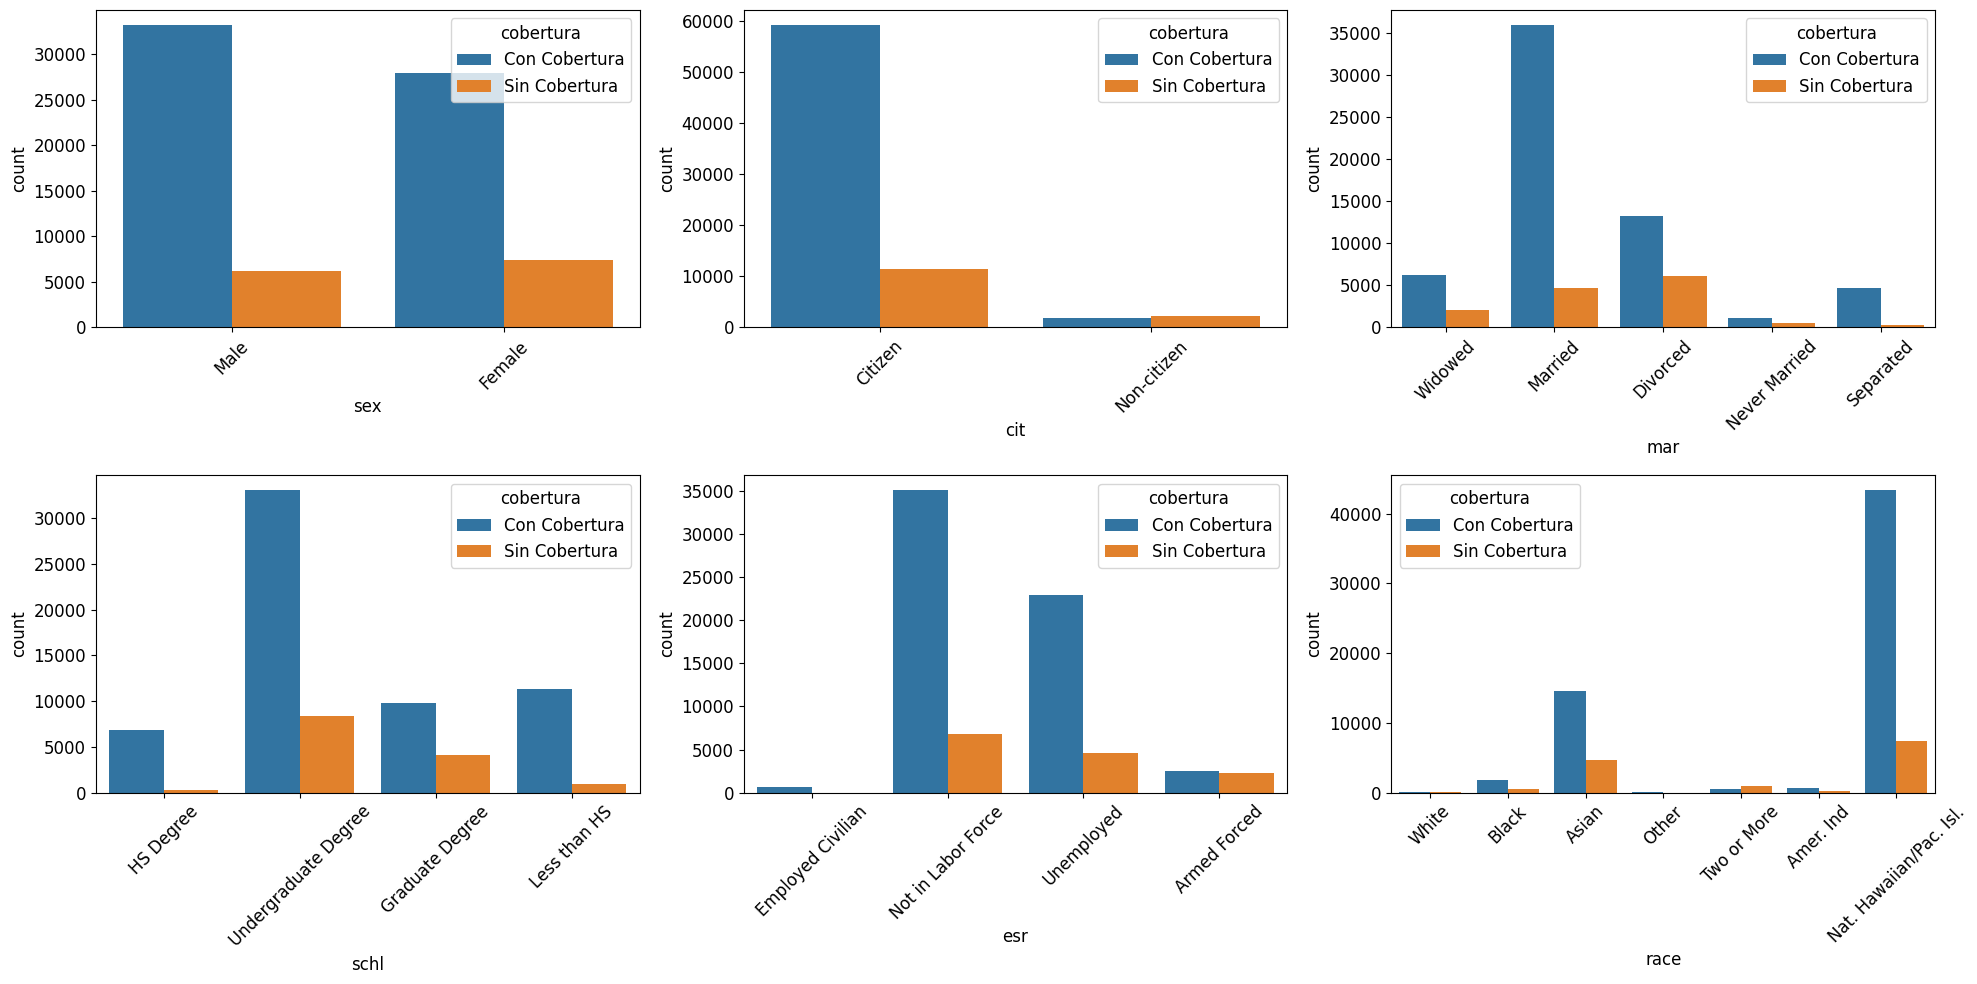

In [ ]:
fig,axes=plt.subplots(2,3)
g1=sns.countplot(data=df,x="sex",hue="cobertura",ax=axes[0,0])
g1.set_xticklabels(labels=labs1,rotation=45)
g2=sns.countplot(data=df,x="cit",hue="cobertura",ax=axes[0,1])
g2.set_xticklabels(labels=labs2,rotation=45)
g3=sns.countplot(data=df,x="mar",hue="cobertura",ax=axes[0,2])
g3.set_xticklabels(labels=labs3,rotation=45)
g4=sns.countplot(data=df,x="schl",hue="cobertura",ax=axes[1,0])
g4.set_xticklabels(labels=labs4,rotation=45)
g5=sns.countplot(data=df,x="esr",hue="cobertura",ax=axes[1,1])
g5.set_xticklabels(labels=labs5,rotation=45)
g6=sns.countplot(data=df,x="race",hue="cobertura",ax=axes[1,2])
g6.set_xticklabels(labels=labs6,rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [7.5, 5]

En general podemos ver que estos gráficos no siempre son muy informativos, sobre todo cuando hay muchas clases que tienen cantidades muy dispares de individuos, ya que no todas las barras se aprecian a la misma escala.

Más aún, tampoco se llega a visualizar lo importante, si la relación en cada clase entre ambas barras es la misma para las personas que tienen cobertura y las personas que no la tienen.

### Gráficos de mosaico

Para evitar estos problemas de visualización, se puede hacer un gráfico de mosaico, que permite comparar lo importante, las **proporciones** en ambas clases.

Para realizar varios gráficos de mosaico, importo la función y agregaremos una función auxiliar definida por nosotros para que los gráficos tengan toda la información pertinente.

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

# La función ps_mosaic define algunas propiedades del gráfico
def ps_mosaic(df,v1,v2):
  df_c=df[[v1,v2]].value_counts()
  K=df_c.shape[0]
  props={}
  labs={}
  for k in range(K):
    AuxInd=df_c.index[k]
    labs[AuxInd]=df_c.values[k]
    if AuxInd[1]=="Con Cobertura":
      props[AuxInd]={'facecolor':'red', 'edgecolor':'white'}
    else:
      props[AuxInd]={'facecolor':'xkcd:aqua','edgecolor':'white'}
  return (props,labs)

Los gráficos de mosaico no se pueden disponer en paneles como los gráficos anteriores de barras, por lo tanto, debemos analizar el vínculo con todas las variables por separado. Ahora procedemos a ver el gráfico de mosaico de la variable `"sex"` para ver si hay una diferencia por sexo en la cobertura médica:

In [ ]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 12

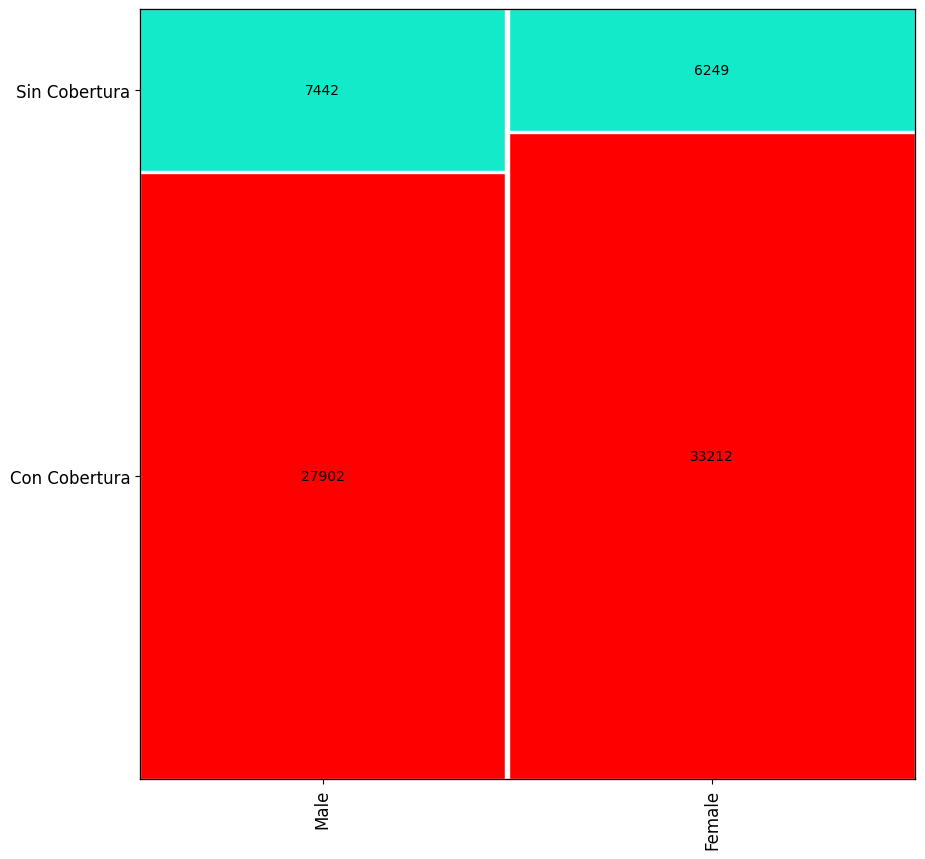

In [ ]:
# Mosaico variable "sex"
v1="sex"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

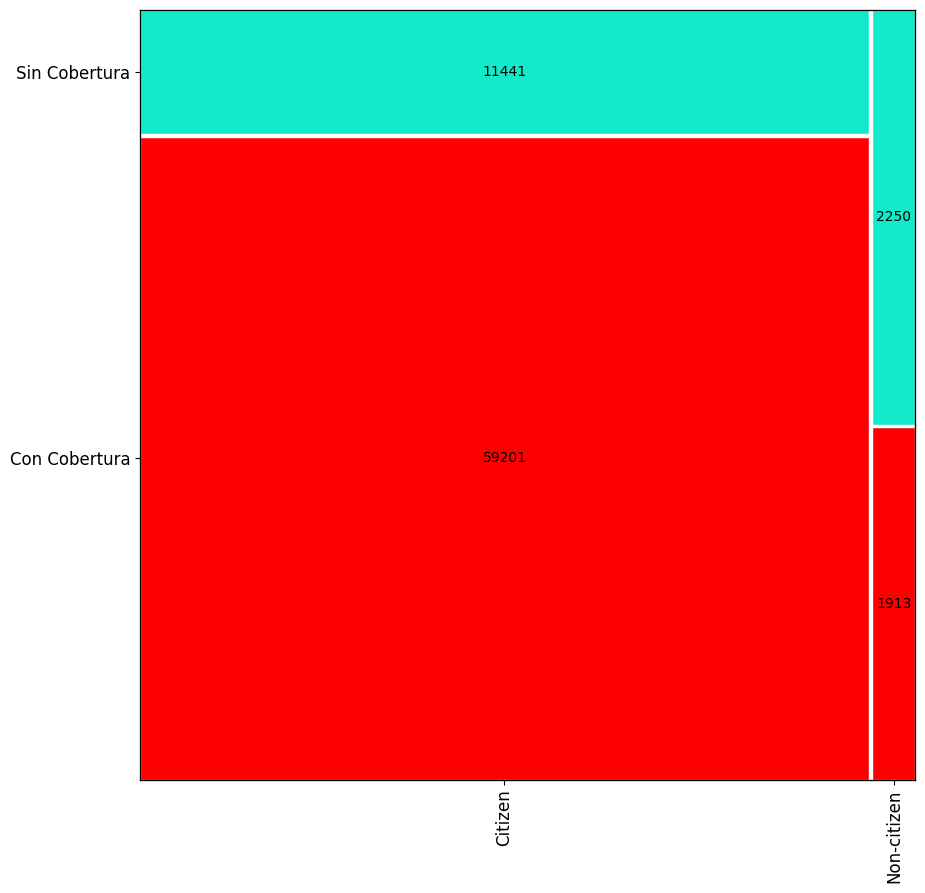

In [ ]:
# Mosaico variable "cit"
v1="cit"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

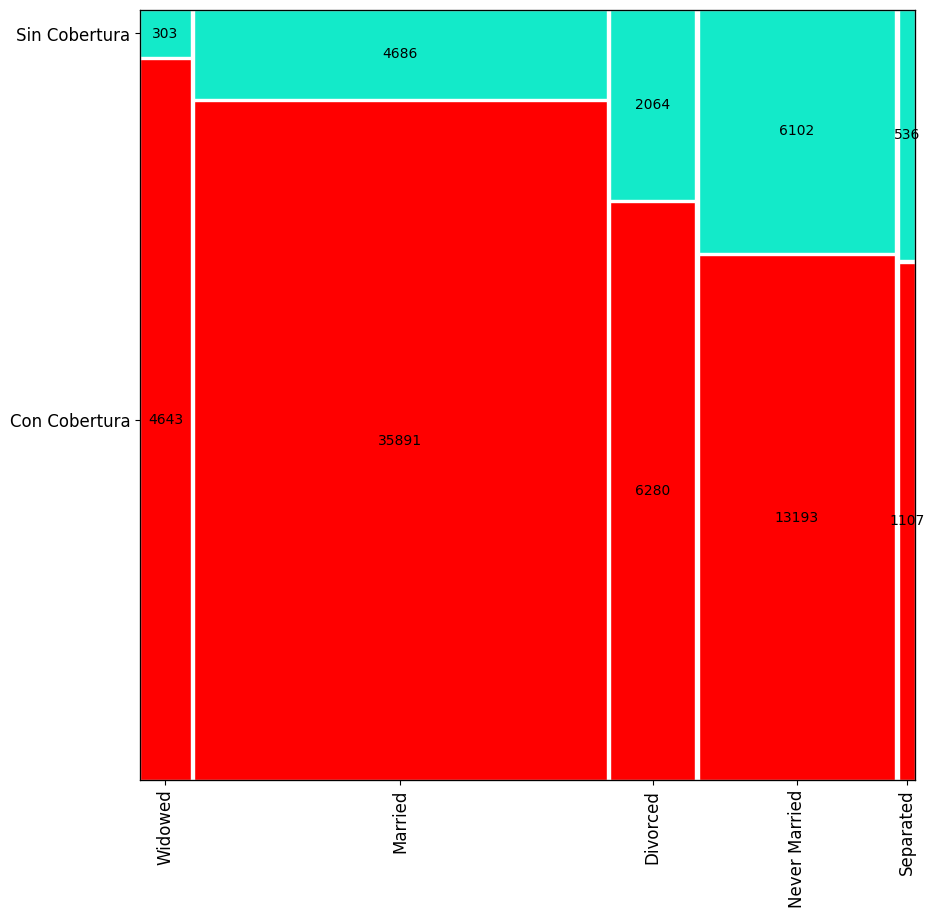

In [ ]:
# Mosaico variable "mar"
v1="mar"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

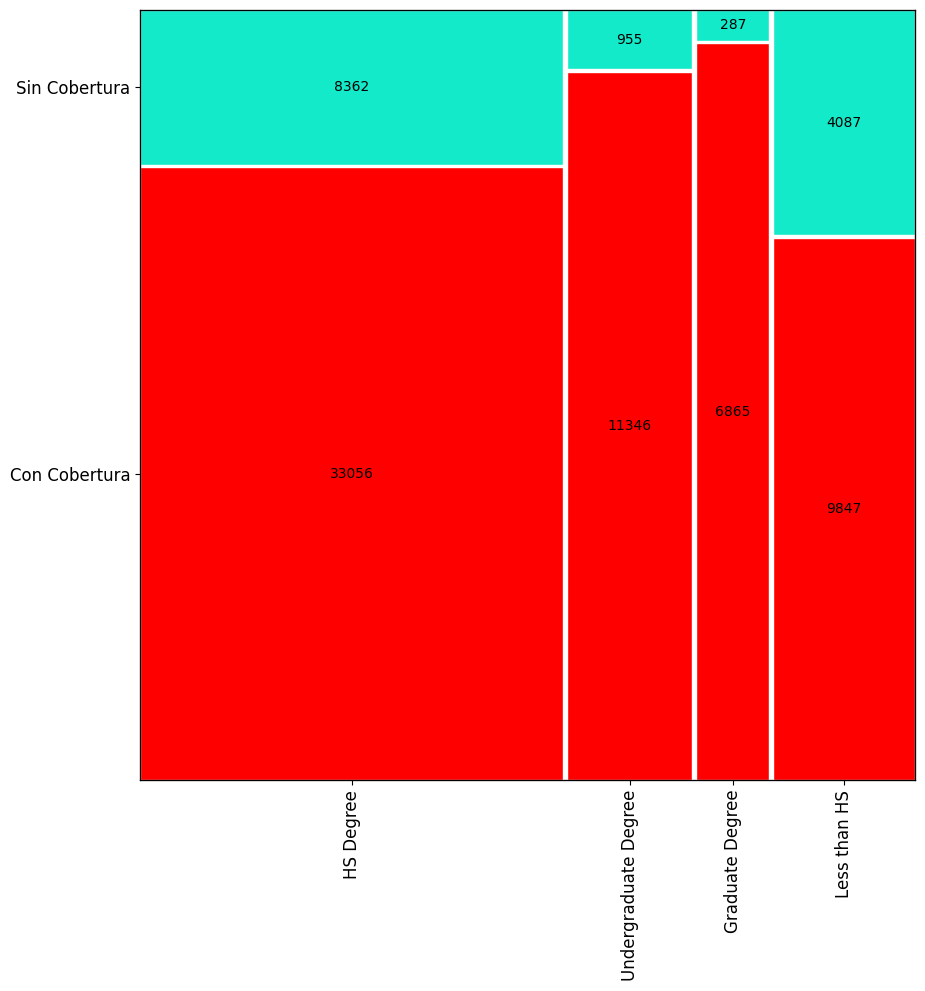

In [ ]:
# Mosaico variable "schl"
v1="schl"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20,10]

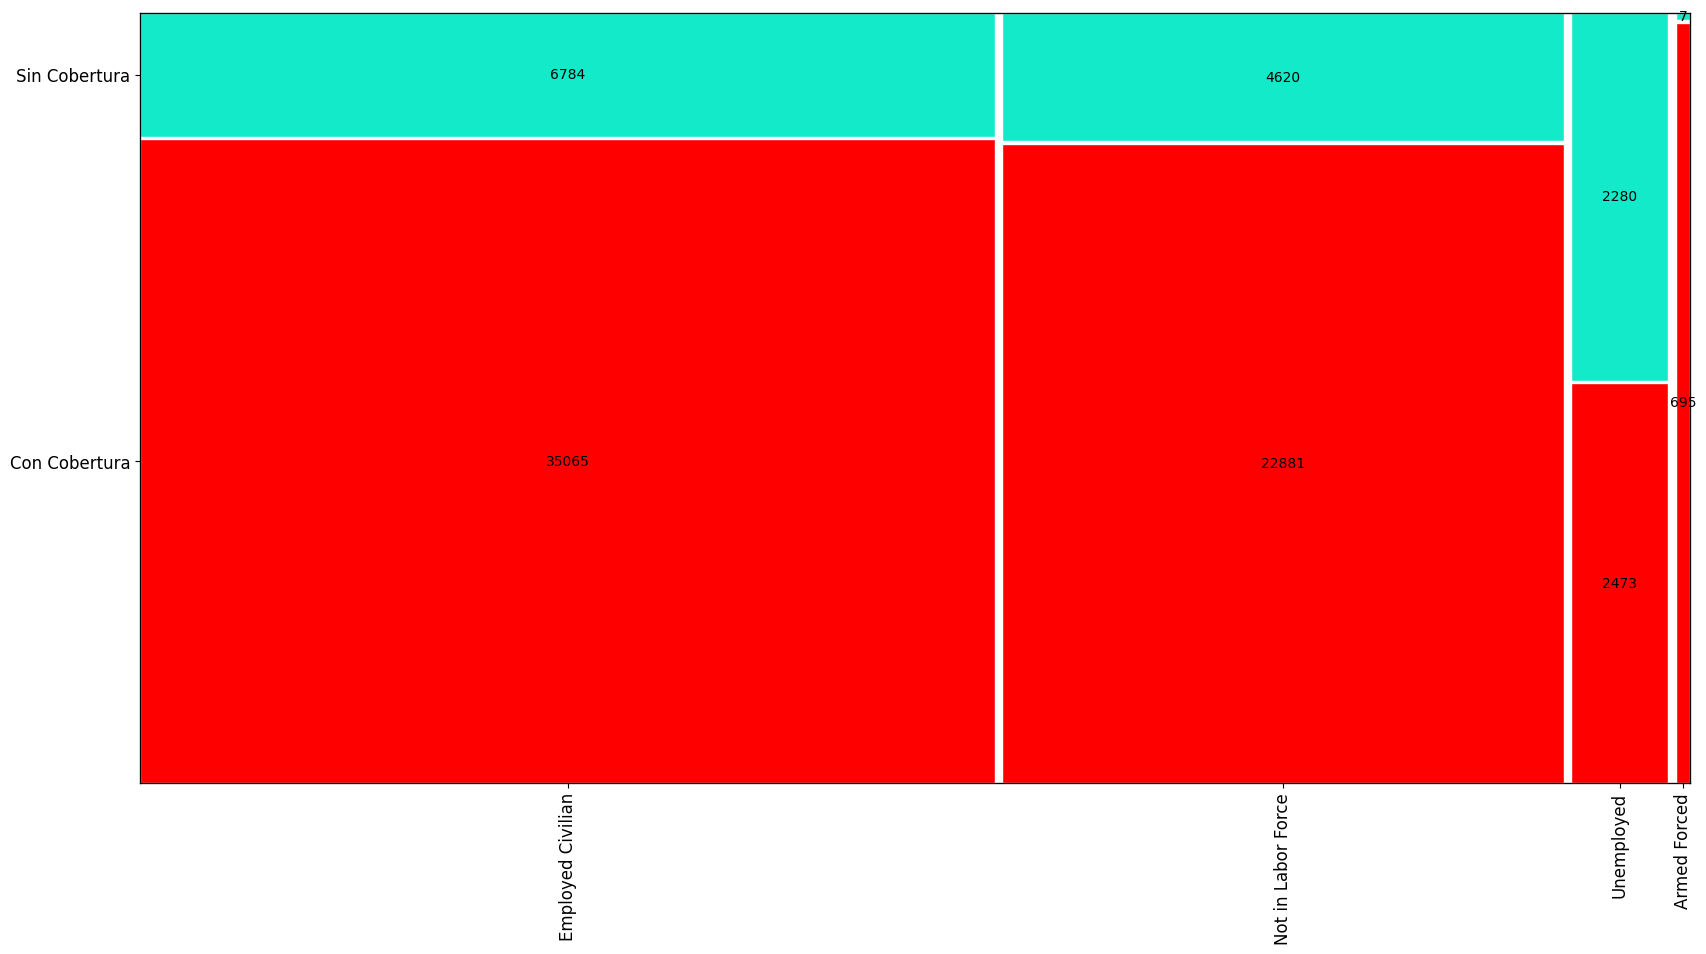

In [ ]:
# Mosaico variable "esr"
v1="esr"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

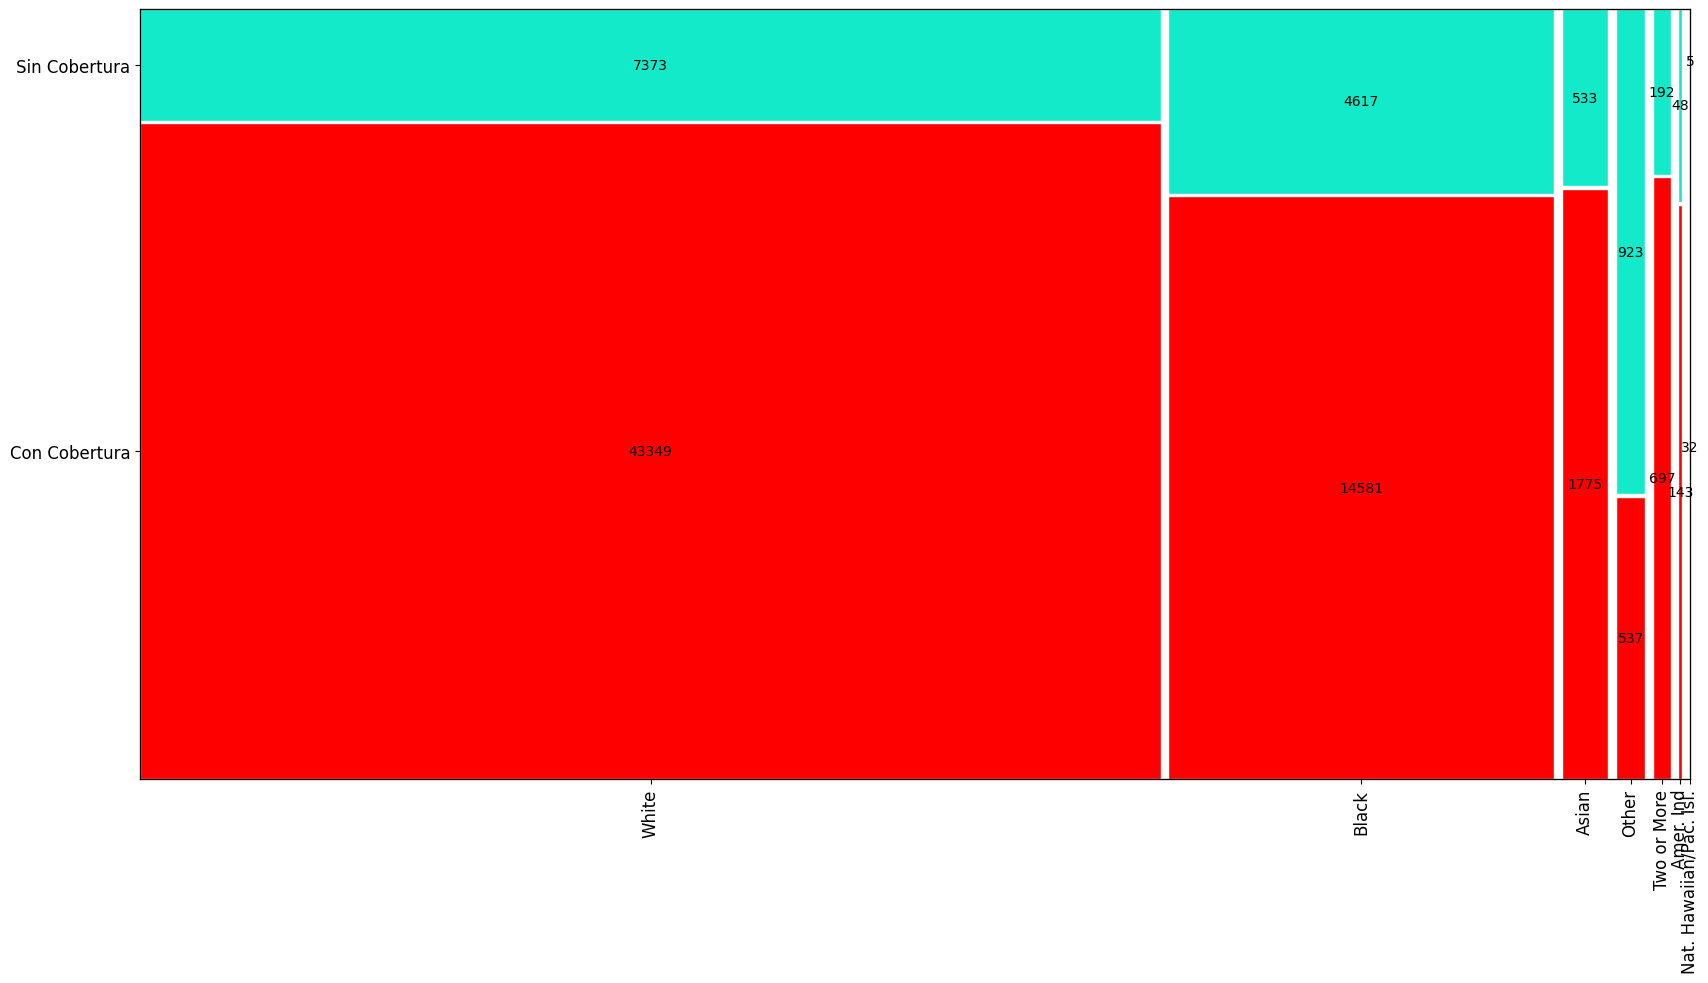

In [ ]:
# Mosaico variable "race"

v1="race"
v2="cobertura"
lis=ps_mosaic(df,v1,v2)
props=lis[0]
labs=lis[1]

labelizer=lambda k:labs[k]

g=mosaic(df,[v1,v2],labelizer=labelizer,properties=props,label_rotation=[90,0])
plt.show()

Por lo tanto, todas las variables parecen influir sobre la probabilidad de tener cobertura o no, ya que en todos los casos, las proporciones son diferentes por cada clase. De todas formas, esto es un primer indicio, hay que darle sustento desde otro enfoque.

## Regresión logística

Ya vimos en las clases anteriores que los vínculos entre variables se evalúan mediante **modelos de regresión**. Según lo visto, plantear un modelo de regresión lineal para establecer un vínculo entre la variable `"no.coverage"` con las variables `"age"`, `"wage"`, `"sex"`, `"cit"`, `"mar"`, `"schl"`, `"esr"` y `"race"` sería plantear el siguiente modelo:
$$ \text{no.coverage} ≈ \beta_0+\beta_1⋅ \text{age} + \beta_2⋅ \text{wage} + \beta_3 ⋅ \text{sex} +\beta_4⋅ \text{cit} + \beta_5⋅ \text{schl} + \beta_6⋅\text{esr} + \beta_7⋅ \text{race}$$

Sin embargo, surge un problema ante esta formulación. Más allá de que hay muchas variables predictoras que son categóricas y deben utilizarse las variables "dummy", la variable `"no.coverage"` toma sólo los valores 0 y 1.

Por lo tanto, los valores de las constantes $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, $\beta_5$, $\beta_6$, $\beta_7$ no son completamente libres, ya que deberían compensarse para que el resultado siempre sea **exactamente** 0 o 1. Esto no tiene mucho sentido, por lo que se necesita una variable de respuesta que tome valores en un continuo.

## Regresión lineal

Supongamos que queremos realizar una regresión lineal con estas variables (utilizando las variables
dummies) y realizamos predicciones para los mismos datos:

In [ ]:
# Cargo los paquetes necesarios
import numpy as np
import pandas as pd
df1=pd.get_dummies(df,columns=["race","sex","cit","mar","schl","esr"])


In [ ]:
# Variable de respuesta
resp=["no.coverage"];
y=df1[resp].copy();
# Cambio el código para que 1 represente que una persona tenga cobertura médica
y=1-y

# Covariables
covs=["age","wage"]
covsR=[dV for dV in df1.columns.values if dV.startswith("race_")]
covs.extend(covsR)
covsS=[dV for dV in df1.columns.values if dV.startswith("sex_")]
covs.extend(covsS)
covsC=[dV for dV in df1.columns.values if dV.startswith("cit_")]
covs.extend(covsC)
covsM=[dV for dV in df1.columns.values if dV.startswith("mar_")]
covs.extend(covsM)
covsSc=[dV for dV in df1.columns.values if dV.startswith("schl_")]
covs.extend(covsSc)
covsE=[dV for dV in df1.columns.values if dV.startswith("esr_")]
covs.extend(covsE)
print(covs)
X=df1[covs].copy()

['age', 'wage', 'race_Amer. Ind', 'race_Asian', 'race_Black', 'race_Nat. Hawaiian/Pac. Isl.', 'race_Other', 'race_Two or More', 'race_White', 'sex_Female', 'sex_Male', 'cit_Citizen', 'cit_Non-citizen', 'mar_Divorced', 'mar_Married', 'mar_Never Married', 'mar_Separated', 'mar_Widowed', 'schl_Graduate Degree', 'schl_HS Degree', 'schl_Less than HS', 'schl_Undergraduate Degree', 'esr_Armed Forced', 'esr_Employed Civilian', 'esr_Not in Labor Force', 'esr_Unemployed']


In [ ]:
from sklearn.linear_model import LinearRegression
mod=LinearRegression()
mod.fit(X,y)
y_pred=mod.predict(X)

Para poder evaluar cómo son las predicciones, podemos graficar las mismas junto conlas respuestas
reales respecto de alguna variable (por ejemplo, la variable de edad):

In [ ]:
plt.rcParams['figure.figsize'] = [10,7.5]

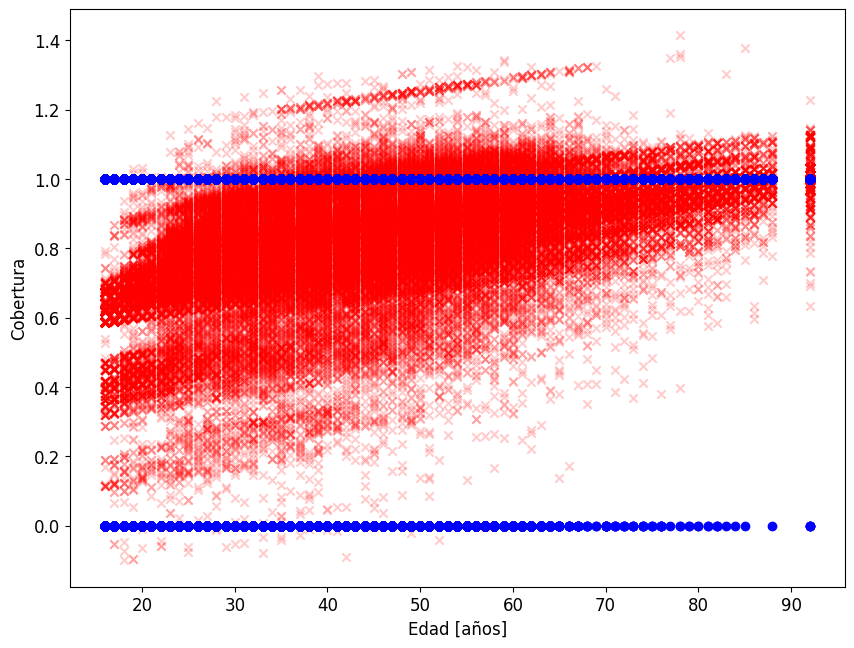

In [ ]:
plt.scatter(X["age"],y_pred,c="r",marker="x",alpha=0.2)
plt.scatter(X["age"],y,c="b")
plt.xlabel("Edad [años]")
plt.ylabel("Cobertura")
plt.show()

Aquí vemos gráficamente que el modelo es erróneo, porque no representa gráficamente a los datos, justamente porque las respuestas deben ser únicamente 1 o 0.

### Nociones de probabilidad

Supongamos que vamos a tirar una moneda. Intuitivamente, tenemos la idea de que la probabilidad de que el resultado sea cara es del 50%. Pero vamos a detenernos a pensar un minuto en qué representa ese valor, para luego poder interpretar el concepto de probabilidad en otros casos.

Una forma de pensar la probabilidad, es pensar en cuán frecuente es algún resultado de un experimento aleatorio. En este caso,
* el experimento es tirar una moneda
* es aleatorio porque no podemos determinar su resultado antes del experimento
* el resultado cuya frecuencia se quiere determinar es que la moneda salga cara

El problema es que para determinar cuán frecuente es algo, necesitamos que el experimento se repita varias veces, y nosotros sólo tiramos la moneda una vez. Pero justamente, podemos interpretar el valor de 50% del siguiente modo: si repitiéramos un gran número de veces el experimento (tirar varias veces una moneda), aproximadamente el 50% de esos resultados serían una cara, ya que la moneda no tiene ninguna preferencia por salir de alguno de los dos lados.



In [ ]:
import numpy as np
N=50
np.random.seed(10)
dfEj=pd.DataFrame({"Tirada":range(1,N),"Resultado":np.random.choice(["cara","ceca"],replace=True,size=N-1)})
dfEj["Caras acumuladas"]=np.cumsum(dfEj["Resultado"]=="cara")
dfEj["Porcentaje Caras"]=dfEj["Caras acumuladas"]*100/dfEj["Tirada"]
print(dfEj)

    Tirada Resultado  Caras acumuladas  Porcentaje Caras
0        1      ceca                 0          0.000000
1        2      ceca                 0          0.000000
2        3      cara                 1         33.333333
3        4      ceca                 1         25.000000
4        5      cara                 2         40.000000
5        6      ceca                 2         33.333333
6        7      ceca                 2         28.571429
7        8      cara                 3         37.500000
8        9      ceca                 3         33.333333
9       10      ceca                 3         30.000000
10      11      cara                 4         36.363636
11      12      ceca                 4         33.333333
12      13      ceca                 4         30.769231
13      14      cara                 5         35.714286
14      15      cara                 6         40.000000
15      16      ceca                 6         37.500000
16      17      cara           

## Probabilidad como respuesta


Por lo tanto, vamos a pensar en la **probabilidad** de que una persona tenga cobertura médica. Es decir, si tuviéramos un gran número de personas **con las mismas características**, ¿qué proporción de ellas tendría cobertura médica?

Por lo tanto, vamos a adaptar el modelo anterior del siguiente modo:
$$ P(\text{cobertura}=1) ≈ \beta_0+\beta_1⋅ \text{age} + \beta_2⋅ \text{wage} + \beta_3 ⋅ \text{sex} +\beta_4⋅ \text{cit} + \beta_5⋅ \text{schl} + \beta_6⋅\text{esr} + \beta_7⋅ \text{race}$$

donde $P$ representa la probabilidad de que la variable `"cobertura"` sea 1. La ventaja de esta propuesta, es que el valor de la probabilidad ya no tiene porqué valer exactamente 0 o 1, sino que puede tomar varios valores. Sin embargo, siguen siendo valores que tienen sentido **entre 0 y 1**. Por lo tanto, los valores de cada constante $\beta$ siguen estando restringidos.

### Odds

Para ampliar el rango de valores posibles, se puede comparar la probabilidad de que una persona tenga cobertura, respecto de la probabilidad de que no la tenga. Para eso se define el siguiente cociente denominado "odds":
$$\text{odds}=\dfrac{P(\text{cobertura}=1)}{P(\text{cobertura}=0)} $$

Considerando que la variable tiene sólo dos valores, en realidad, se puede expresar del siguiente modo:
$$P(\text{cobertura}=0)=1-P(\text{cobertura}=1)$$

Entonces, podemos reescribir el odds del siguiente modo:
$$\text{odds}=\dfrac{P(\text{cobertura}=1)}{1-P(\text{cobertura}=1)} $$

* A partir de esta división, si el resultado es mayor que 1, significa que es más probable que una persona tenga cobertura, respecto de que no la tenga. Más aún, si el resultado del cociente es 8, significa que la probabilidad de que una persona tenga cobertura es 8 veces más grande que la probabilidad de que no la tenga.

* Del mismo modo, si el resultado es menor que 1, significa que es menos probable que una persona tenga cobertura, respecto de las personas sin seguro médico.

* El caso en el que el odds vale 1, representa una probabilidad de $\frac{1}{2}=0.5$.

Por lo tanto, podemos actualizar el modelo del siguiente modo:
$$ \text{odds}=\dfrac{P(\text{cobertura}=1)}{1-P(\text{cobertura}=1)} ≈ \beta_0+\beta_1⋅ \text{age} + \beta_2⋅ \text{wage} + \beta_3 ⋅ \text{sex} +\beta_4⋅ \text{cit} + \beta_5⋅ \text{schl} + \beta_6⋅\text{esr} + \beta_7⋅ \text{race}$$


Respecto a los valores que puede tomar el odds,
* si el valor de $P(\text{cobertura}=1)$ es cercano a 0, el denominador es cercano a 1 y el resultado del odds es cercano a 0
* si el valor de $P(\text{cobertura}=1)$ es cercano a 1, el denominador es cercano a 0 y el resultado del odds puede tomar valores muy altos, abarcando cualquier número positivo.

De todas formas, el resultado del odds siempre es **positivo**. Por lo tanto, sigue habiendo una restricción para las constantes $\beta$.


### Log Odds

Para resolver todo tipo de restricción, se puede tomar el logaritmo natural al cociente odds, ya que al aplicarlo a cualquier número positivo, el logaritmo puede tomar cualquier valor real, ya sea positivo o negativo.

Entonces, el modelo final que se plantea es el siguiente:
$$ \text{log}(  \text{odds})=\text{log}\left(  \dfrac{P(\text{cobertura}=1)}{1-P(\text{cobertura}=1)} \right) ≈ \beta_0+\beta_1⋅ \text{age} + \beta_2⋅ \text{wage} + \beta_3 ⋅ \text{sex} +\beta_4⋅ \text{cit} + \beta_5⋅ \text{schl} + \beta_6⋅\text{esr} + \beta_7⋅ \text{race}$$

En este caso, como el logaritmo puede tomar cualquier valor real, las constantes $\beta$ ya no tienen ningún tipo de restricción. Por lo tanto, buscamos que los coeficientes estimados se atengan a este modelo. La función log(odds($p$)) es a veces llamada "logit".


## Explicación gráfica

El vínculo entre las probabilidades $p$, el odds y el log odds, lo podemos ver dándole valores a $p$:

In [ ]:
ps=np.linspace(0.1,0.9,9)
odds=ps/(1-ps)
lOdds=np.log(odds)
df_odds=pd.DataFrame({"p":ps,"odds":odds,"lOdds":lOdds})
print(df_odds)

     p      odds     lOdds
0  0.1  0.111111 -2.197225
1  0.2  0.250000 -1.386294
2  0.3  0.428571 -0.847298
3  0.4  0.666667 -0.405465
4  0.5  1.000000  0.000000
5  0.6  1.500000  0.405465
6  0.7  2.333333  0.847298
7  0.8  4.000000  1.386294
8  0.9  9.000000  2.197225


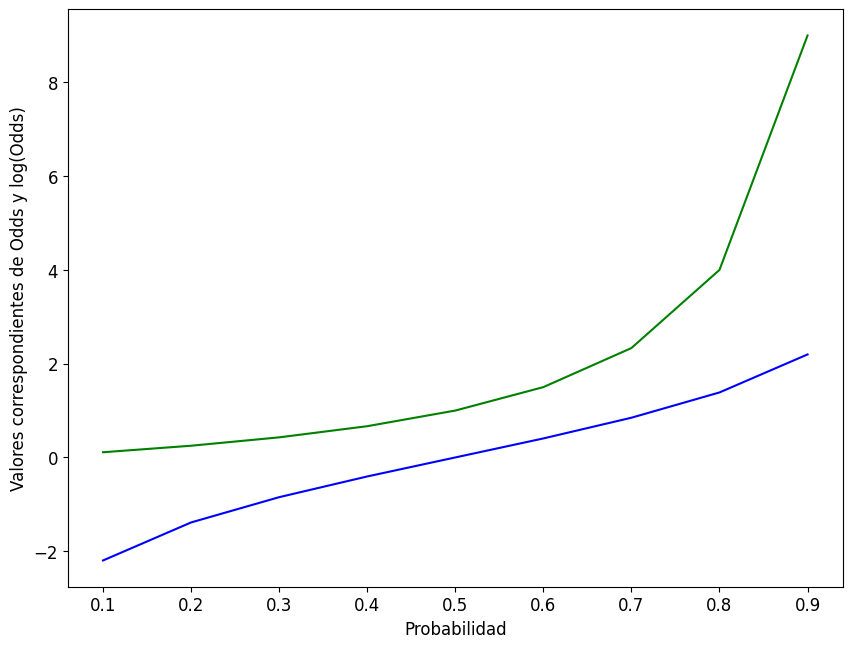

In [ ]:
plt.plot(ps,odds,c="g")
plt.plot(ps,lOdds,c="b")
plt.xlabel("Probabilidad")
plt.ylabel("Valores correspondientes de Odds y log(Odds)")
plt.show()

## Estimación

Ahora que ya tenemos el modelo, debemos encontrar los valores óptimos para los coeficientes $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, $\beta_5$, $\beta_6$ y $\beta_7$. Estos valores deben buscarse con algún criterio razonable. En este caso, a diferencia de lo observado en regresión lineal, se apela a los "estimadores de máxima verosimilitud".

La idea es la siguiente: Se tiene como dato tanto la cobertura médica o no de cada individuo, y de las variables que influyen sobre dicha condición. A su vez, según el modelo, cada variable tiene una cierta influencia sobre la probabilidad de cobertura (a través de cada $\beta$).

¿Cuáles son los valores de $\beta$ que, a partir de las variables explicativa, aumentan la probabilidad de tener cobertura médica entre los que la tienen y, al mismo tiempo, aumentan la probabilidad de no tener cobertura médica entre los que no la tienen?

Es decir, dados los datos de cobertura y las variables explicativas, ¿cuáles son los valores más verosímiles para $\beta$?



# Estimación en Python

Para estimar los valores de $\beta$, en Python se utiliza la función `LogisticRegression` del paquete `sklearn`. Recordemos que inicialmente, para todas las variables categóricas, debemos generar las variables dummy.

In [ ]:
# Cargo los paquetes necesarios
import numpy as np
import pandas as pd
df1=pd.get_dummies(df,columns=["race","sex","cit","mar","schl","esr"])

Ahora que tenemos las variables dummy, seleccionamos la variable de respuesta y las variables explicativas o covariables.

In [ ]:
# Variable de respuesta
resp=["no.coverage"];
y=df1[resp].copy();
# Cambio el código para que 1 represente que una persona tenga cobertura médica
y=1-y

# Covariables
covs=["age","wage"]
covsR=[dV for dV in df1.columns.values if dV.startswith("race_")]
covs.extend(covsR)
covsS=[dV for dV in df1.columns.values if dV.startswith("sex_")]
covs.extend(covsS)
covsC=[dV for dV in df1.columns.values if dV.startswith("cit_")]
covs.extend(covsC)
covsM=[dV for dV in df1.columns.values if dV.startswith("mar_")]
covs.extend(covsM)
covsSc=[dV for dV in df1.columns.values if dV.startswith("schl_")]
covs.extend(covsSc)
covsE=[dV for dV in df1.columns.values if dV.startswith("esr_")]
covs.extend(covsE)
print(covs)
X=df1[covs].copy()

['age', 'wage', 'race_Amer. Ind', 'race_Asian', 'race_Black', 'race_Nat. Hawaiian/Pac. Isl.', 'race_Other', 'race_Two or More', 'race_White', 'sex_Female', 'sex_Male', 'cit_Citizen', 'cit_Non-citizen', 'mar_Divorced', 'mar_Married', 'mar_Never Married', 'mar_Separated', 'mar_Widowed', 'schl_Graduate Degree', 'schl_HS Degree', 'schl_Less than HS', 'schl_Undergraduate Degree', 'esr_Armed Forced', 'esr_Employed Civilian', 'esr_Not in Labor Force', 'esr_Unemployed']


Ahora que tenemos los datos correspondientes para la regresión logística, calculamos los valores de los $\beta$ con la función `LogisticRegression`:

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X,y)
coefs=logreg.coef_[0]
dic={}
for key,val in list(zip(covs,coefs)):
  dic[key]=val
df_coef=pd.DataFrame(dic,index=[" "])
print(df_coef)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        age      wage  race_Amer. Ind  race_Asian  race_Black  \
   0.030652  0.025321       -0.026414    0.172573   -0.148172   

   race_Nat. Hawaiian/Pac. Isl.  race_Other  race_Two or More  race_White  \
                       0.017214   -0.810115          0.136082    0.176989   

   sex_Female  ...  mar_Separated  mar_Widowed  schl_Graduate Degree  \
    -0.027962  ...      -0.682577     0.432277              0.651926   

   schl_HS Degree  schl_Less than HS  schl_Undergraduate Degree  \
        -0.603969          -0.656847                   0.127048   

   esr_Armed Forced  esr_Employed Civilian  esr_Not in Labor Force  \
           0.710962              -0.282134                 0.18883   

   esr_Unemployed  
        -1.099499  

[1 rows x 26 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Interpretación de los coeficientes

Analizaremos el primer coeficiente, que corresponde a la variable de edad ($\beta_1=0.03065163$). La interpretación inicial es similar a la de la regresión múltiple, sólo que debe adaptarse al modelo elegido, cuya variable de respuesta es el $\text{log(odds)}$.

Es decir, **manteniendo todas las otras variables constantes**, cada año extra que vive una persona *aumenta* (el signo es positivo) en 0.03065163 el valor estimado del $\text{log(odds)}$ de tener cobertura médica.

Para independizarse del logaritmo, se aplica una función exponencial, utilizando el número irracional $e\approx 2.71$. Por lo tanto, **manteniendo todas las otras variables constantes**, cada año extra que vive una persona *aumenta* en $e^{0.03065163}\approx 1.0311$ el valor estimado del $\text{odds}$ de tener cobertura médica, que se calcula del siguiente modo: $\dfrac{P(\text{cobertura}=1)}{1-P(\text{cobertura}=1)}$.

Sigue sin ser muy interpretable, pero despejando, se puede demostrar que el impacto estimado de cada año vivido sobre la probabilidad de tener seguro médico (manteniendo todas las otras variables constantes) viene dada por la siguiente fórmula
$$\dfrac{e^{\beta_1}}{1+e^{\beta_1}}≈ \dfrac{e^{0.03065163}}{1+e^{0.03065163}}\approx 0.5077 $$

De todas formas, se puede hacer una interpretación más rudimentaria, en la que se pueden asociar los signos negativos de los coeficientes con una reducción en la probabilidad de tener cobertura médica, mientras que se da lo inverso para coeficientes positivos. A medida que estos coeficientes se alejan del cero, tiene más influencia sobre
la probabilidad estimada de tener cobertura médica.

### Predicción de probabilidad

En python, una vez estimados los coeficientes $\beta$, se puede estimar la probabilidad estimada de tener cobertura sabiendo los valores de las variables predictivas.

Rápidamente, en python se puede hacer del siguiente modo, estimando por ejemplo, la probabilidad de el primer individuo (fila 0) tenga cobertura médica:

In [ ]:
print(logreg.predict_proba(X)[0,1])

0.9677999736808303


Recordemos cómo se interpreta esta probabilidad. El hecho de que dé como resultado 97.66% significa que, según el modelo, si se tuvieran un gran número de personas con las mismas características que ese individuo, aproximadamente el 97.66% de ellas tendría cobertura médica.

## Verificación del cálculo



Para ver cómo se obtiene este valor, explicaremos a continuación cómo se puede estimar la probabilidad para el primer individuo. Primero vemos los valores de las variables para este individuo y los coeficientes correspondientes

In [ ]:
print(X.iloc[[0],:])
print(df_coef)

   age  wage  race_Amer. Ind  race_Asian  race_Black  \
0   60  66.0               0           0           0   

   race_Nat. Hawaiian/Pac. Isl.  race_Other  race_Two or More  race_White  \
0                             0           0                 0           1   

   sex_Female  ...  mar_Separated  mar_Widowed  schl_Graduate Degree  \
0           0  ...              0            1                     0   

   schl_HS Degree  schl_Less than HS  schl_Undergraduate Degree  \
0               1                  0                          0   

   esr_Armed Forced  esr_Employed Civilian  esr_Not in Labor Force  \
0                 0                      1                       0   

   esr_Unemployed  
0               0  

[1 rows x 26 columns]
        age      wage  race_Amer. Ind  race_Asian  race_Black  \
   0.030652  0.025321       -0.026414    0.172573   -0.148172   

   race_Nat. Hawaiian/Pac. Isl.  race_Other  race_Two or More  race_White  \
                       0.017214   -0.810

In [ ]:
print(X.iloc[[0],:].values)

[[60. 66.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.
   0.  1.  0.  0.  0.  1.  0.  0.]]


Multiplicando cada valor con su respectivo $\beta$ se obtiene lo
siguiente:

In [ ]:
dfProd=X.iloc[[0],:]*logreg.coef_
print(dfProd)
print(0.03065163*60)
print(0.02532117*66)

        age      wage  race_Amer. Ind  race_Asian  race_Black  \
0  1.839098  1.671197            -0.0         0.0        -0.0   

   race_Nat. Hawaiian/Pac. Isl.  race_Other  race_Two or More  race_White  \
0                           0.0        -0.0               0.0    0.176989   

   sex_Female  ...  mar_Separated  mar_Widowed  schl_Graduate Degree  \
0        -0.0  ...           -0.0     0.432277                   0.0   

   schl_HS Degree  schl_Less than HS  schl_Undergraduate Degree  \
0       -0.603969               -0.0                        0.0   

   esr_Armed Forced  esr_Employed Civilian  esr_Not in Labor Force  \
0               0.0              -0.282134                     0.0   

   esr_Unemployed  
0            -0.0  

[1 rows x 26 columns]
1.8390978
1.67119722


Entonces, sumando todos estos valores se obtiene la estimación del $\text{log(odds)}$:


In [ ]:
expo=np.sum(dfProd.values)
print(expo)

3.4030581572488288


Recordando cómo se obtiene la probabilidad a partir del $\text{log(odds)}$, se termina obteniendo el valor estimado de la probabilidad del siguiente modo:
$$\widehat{p}=\dfrac{e^{\text{log(odds)}}}{1+e^{\text{log(odds)}}}$$

Vemos que con esta cuenta da como resultado el mismo que la predicción dada por python.

In [ ]:
prob=np.exp(expo)/(1+np.exp(expo))
print(prob)

0.9677999736808304


Ahora, en el siguiente vector, vamos a guardar las probabilidades
estimadas para todos los individuos.

In [ ]:
y_pred_probs = logreg.predict_proba(X)[:, 1]
print(y_pred_probs[range(5)])

[0.96779997 0.94911896 0.95148466 0.97996217 0.94817449]


### Predicción de respuesta

De todas formas, en la práctica, estas probabilidades estimadas pueden servir para hacer un análisis fino de la cobertura médica, pero en definitiva, para nuevas observaciones queremos saber más que nada si para una nueva observación, predecimos si va a tener cobertura medica o no. Es decir, es de interés clasificar a cada individuo según la primer variable binaria que utilizamos como variable de respuesta.

Para clasificar los nuevos individuos según si tienen cobertura o no, el criterio por default para la regresión logística sería clasificarlos como personas con cobertura médica si la probabilidad estimada es mayor que 50% y clasificarla como sin cobertura en caso contrario. Eso en python se hace con el método `predict`:

In [ ]:
y_pred=logreg.predict(X)
print(y_pred_probs[range(5)])
print(y_pred[range(5)])

[0.96779997 0.94911896 0.95148466 0.97996217 0.94817449]
[1. 1. 1. 1. 1.]


Podemos ver que los individuos clasificados como 1 tienen probabilidad estimada mayor que 0.5 y los clasificados como 0 tienen probabilidad estimada por debajo de 0.5:

In [ ]:
Ind1=np.where(y_pred==1)
print(y_pred_probs[Ind1])
print(y_pred[Ind1])
Ind0=np.where(y_pred==0)
print(y_pred_probs[Ind0])
print(y_pred[Ind0])

[0.96779997 0.94911896 0.95148466 ... 0.99887735 0.88699651 0.9736503 ]
[1. 1. 1. ... 1. 1. 1.]
[0.43947055 0.39983114 0.37197409 ... 0.42790857 0.46762629 0.41316799]
[0. 0. 0. ... 0. 0. 0.]


## Verificación gráfica

Ahora que se pueden predecir las respuestas binarias, repetimos el gráfico en el que se superponen los valores reales con los predichos para ver que el modelo se adapta mejor a los datos que la regresión lineal:

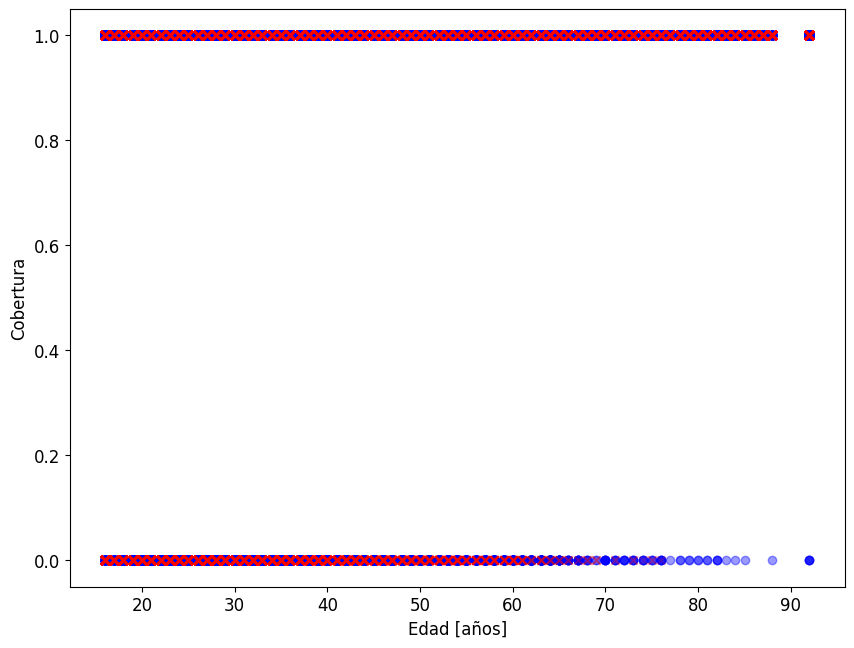

In [ ]:
plt.scatter(X["age"],y,alpha=0.4,c="b")
plt.scatter(X["age"],y_pred,alpha=0.2,c="r",marker="x")
plt.xlabel("Edad [años]")
plt.ylabel("Cobertura")
plt.show()

## Evaluación de los resultados

Estas predicciones pueden tener errores, y en este caso
sabemos las respuestas reales. Para evaluar la calidad de estas predicciones, podemos generar lo que se llama una matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
CMat=confusion_matrix(y, y_pred)
dfCM=pd.DataFrame({"Clas s/SM":CMat[:,0],"Clas c/SM":CMat[:,1]},index=["s/SM","c/SM"])
print(dfCM)

      Clas s/SM  Clas c/SM
s/SM       3173      10518
c/SM       1902      59212


De todas las predicciones, las que son correctas están sobre la diagonal, ya que coincide la clase real con la estimada. Es decir, si consideramos que una persona con seguro médico es una detección "positiva", tendríamos:

* 3173 verdaderos "negativos"

* 1902 falsos "negativos"

* 10518 falsos "positivos"

* 59212 verdaderos "positivos"

Esto da lugar a una primer métrica de calidad de clasificación denominada "accuracy" y en python se calcula del siguiente modo:

In [ ]:
print(logreg.score(X,y))

0.8339683176258271


Es decir, bajo estas estimaciones, se predicen correctamente el 83.39% de los datos.

Sin embargo, pueden haber métricas más complicadas, que evalúan si hay tendencias de clasificaciones erróneas en algunas clases particulares.

* Por ejemplo, notemos que entre los clasificados como "negativos", es mayor la proporción de falsos negativos ($\frac{\text{Falsos negativos}}{\text{Clasificados Negativos}}=\frac{1902}{1902+3173} \approx 0.3748$) que la proporción de falsos positivos  entre los clasificados  como "positivos" ($\frac{\text{Falsos positivos}}{\text{Clasificados Positivos}}=\frac{10518}{10518+59212}\approx 0.1508$).

* Del mismo modo, entre los realmente "negativos", las clasificaciones incorrectas son una proporción elevada ($\frac{\text{Falsos negativos}}{\text{Negativos totales}}=\frac{10518}{10518+3173}\approx 0.7682$), respecto de las clasificaciones incorrectas entre los realmente "positivos" ($\frac{\text{Falsos positivos}}{\text{Positivos totales}}=\frac{1902}{1902+59212}\approx 0.03112$).  

Estas magnitudes van mostrando que los errores al predecir las respuestas de los individuos sin cobertura médica son mayores que los errores al predecir los errores de los individuos con cobertura médica. Es decir, la regresión logística propuesta predice mejor a la clase mayoritaria de las personas con seguro médico. El valor del "accuracy" no permitía ver estos sesgos.

Estas cuestiones se pueden ver con la función `classification_report`.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.23      0.34     13691
         1.0       0.85      0.97      0.91     61114

    accuracy                           0.83     74805
   macro avg       0.74      0.60      0.62     74805
weighted avg       0.81      0.83      0.80     74805



Interpretando estos valores,

* la métrica "precision" representa cuantas de las clasificaciones de cada clase son correctas. Es decir:
$$\frac{\text{Verdaderos negativos}}{\text{Clasificados Negativos}}= \frac{3173}{1902+3173} \approx 0.63;\quad \frac{\text{Verdaderos positivos}}{\text{Clasificados Positivos}}=\frac{59212}{10518+59212}\approx 0.85 $$

* la métrica "recall" representa la proporción de cada clase que fueron correctamente clasificadas. Es decir:
$$ \frac{\text{Verdaderos negativos}}{\text{Negativos totales}}=\frac{3173}{10518+3173}\approx 0.23; \quad \frac{\text{Verdaderos positivos}}{\text{Positivos totales}}=\frac{59212}{1902+59212}\approx 0.97 $$

* la métrica "f1-score" combina de forma equitativa tanto las métricas "precision" y "recall", aunque no es exactamente un promedio entre ambas.

Vemos acá que las métricas correspondientes a las personas sin seguro médico son mucho menores respecto de las que sí lo tienen. Es decir, la regresión logística propuesta predice mejor a la clase mayoritaria de las personas con seguro médico.

### Curva ROC

Otra forma de evaluar la calidad de un clasificador binario es utilizando lo que se llama la curva ROC (Receiver Operating Characteristic), en el que se evalúan en simultáneo los falsos y los verdaderos positivos. Los primeros se ubican en la coordenada x y los segundos en la coordenada y.

Hemos visto que según la clasificación como "positiva" (con valor 1) si la probabilidad estimada era mayor que 0.5 y "negativa" (con valor 0) si la probabilidad estimada era menor que 0.5, obtuvimos una proporción de falsos positivos entre los realmente negativos dada por $x=\dfrac{10518}{3173+10518}\approx 0.7682$ mientras que entre los positivos, la proporción de verdaderos positivos es $y=\dfrac{59212}{59212+1902}\approx 0.9689$. En el plano ROC, se grafica el punto del siguiente modo:

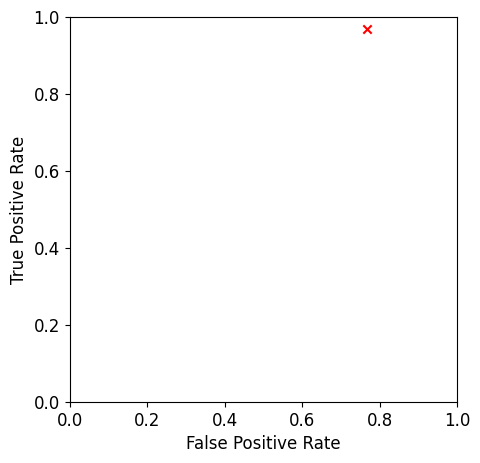

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
x1=10518/(10518+3173)
y1=59212/(59212+1902)
plt.scatter(x1,y1,c="r",marker="x")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

De todas formas, una vez estimadas las probabilidades, se pueden establecer distintos umbrales (en vez de 0.5) a partir de los cuales, las probabilidades estimadas por debajo de dicho valor, se clasifiquen como 0 y en caso contrario, se clasifiquen como 1. Ahora mostraremos tomando como umbrales 0.1, 0.25, 0.75, 0.9.

In [ ]:
  y_pred_Aux=(y_pred_probs>=0.75) * 1
  CMat=confusion_matrix(y, y_pred_Aux)
  xs=CMat[0,1]/np.sum(CMat[0,:])
  ys=CMat[1,1]/np.sum(CMat[1,:])
  print(CMat)
  print(xs)
  print(5065/(8626+5065))
  print(ys)
  print(49234/(11880+49234))


[[ 8626  5065]
 [11880 49234]]
0.3699510627419473
0.3699510627419473
0.8056091893837746
0.8056091893837746


In [ ]:
ps=[0.1,0.25,0.75,0.9];xs=[0]*4;ys=[0]*4;lCM=[0]*4
for i in range(4):
  y_pred_Aux=(y_pred_probs>=ps[i]) * 1
  CMat=confusion_matrix(y, y_pred_Aux)
  xs[i]=CMat[0,1]/np.sum(CMat[0,:])
  ys[i]=CMat[1,1]/np.sum(CMat[1,:])
  lCM[i]=pd.DataFrame({"Clas s/SM":CMat[:,0],"Clas c/SM":CMat[:,1]},index=["s/SM","c/SM"])
  print("p="+str(ps[i]))
  print("Matriz de confusión:")
  print(lCM[i])
  print("Tasa Falsos Positivos:"+str(xs[i]))
  print("Tasa Verdaderos Positivos:"+str(ys[i]))

p=0.1
Matriz de confusión:
      Clas s/SM  Clas c/SM
s/SM        159      13532
c/SM         20      61094
Tasa Falsos Positivos:0.988386531297933
Tasa Verdaderos Positivos:0.9996727427430703
p=0.25
Matriz de confusión:
      Clas s/SM  Clas c/SM
s/SM        887      12804
c/SM        274      60840
Tasa Falsos Positivos:0.9352129135928712
Tasa Verdaderos Positivos:0.9955165755800635
p=0.75
Matriz de confusión:
      Clas s/SM  Clas c/SM
s/SM       8626       5065
c/SM      11880      49234
Tasa Falsos Positivos:0.3699510627419473
Tasa Verdaderos Positivos:0.8056091893837746
p=0.9
Matriz de confusión:
      Clas s/SM  Clas c/SM
s/SM      12494       1197
c/SM      27851      33263
Tasa Falsos Positivos:0.08742969834197648
Tasa Verdaderos Positivos:0.5442779068625847


Vemos que menores umbrales dan mayor número de detecciones "positivas" y por lo tanto, mayor proporción de verdaderos positivos pero a costa de mayores falsos positivos. Sumemos al gráfico estos puntos:

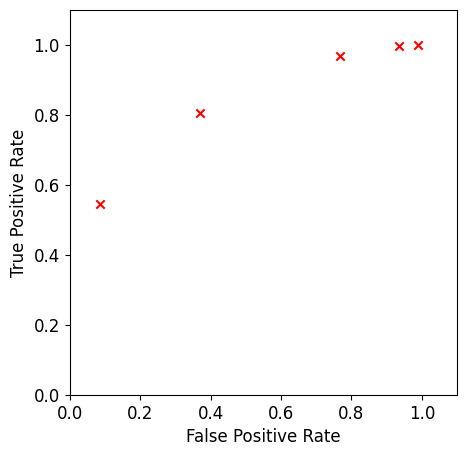

In [ ]:
plt.scatter(x1,y1,c="r",marker="x")
plt.scatter(xs,ys,c="r",marker="x")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Dando muchos más valores a los umbrales, recorriendo valores entre 0 y 1, se pueden unir con una línea y obtener la curva que se denomina "Curva ROC":

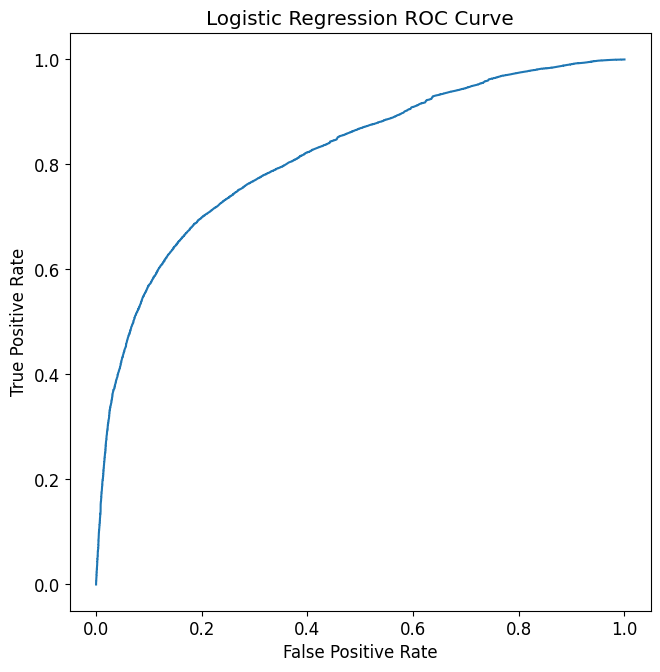

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, y_pred_probs)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

Obviamente no tenemos detecciones perfectas, pero si pudiéramos tenerlas al menos como objetivo, tendríamos un 0% de falsos positivos y un 100% de verdaderos positivos. Es decir, la detección perfecta está en el punto (0,1) de ese espacio (la esquina superior izquierda). Por lo tanto, mientras más se acerquen la combinaciones de falsos positivos y verdaderos positivos a ese punto, mejor serán las clasificaciones. Por lo tanto, muchas veces se suele calcular el área bajo esa curva, para evaluar cuánto se acerca la curva a ese valor óptimo.

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, y_pred_probs))

0.8175553580772248


Esta área tiene un valor máximo de 1 (área del cuadrado que limita ambas coordenadas), mientras que las áreas debajo de 0.5 (correspondiente al triángulo bajo la diagonal) dan muestras de malas clasificaciones, ya que tendría menor rendimiento que asignar al azar 50% de las observaciones a una clase y al otro 50% a la clase restante.

## Comparación de métricas con otro modelo

Supongamos que planteamos un peor modelo, en el que el hecho de tener cobertura médica depende **únicamente** de la edad de la persona. Por lo que hemos visto, hay muchos más factores que influyen sobre la cobertura médica, por lo que deberían arrojar peores métricas de evaluación:

In [ ]:
X0=df[["age"]]
logreg0 = LogisticRegression(fit_intercept=False)
logreg0.fit(X0,y)
print(logreg0.coef_[0])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.0358986]


In [ ]:
y_pred0=logreg0.predict(X0)
y_pred_probs0=logreg0.predict_proba(X0)[:,1]
print(y_pred0)
print(y_pred_probs0)

[1. 1. 1. ... 1. 1. 1.]
[0.89603414 0.82913913 0.80782577 ... 0.86607913 0.86607913 0.96452033]


Veamos cuánto da la métrica "accuracy":


In [ ]:
print("Accuracy modelo completo:")
print(logreg.score(X,y))
print("Accuracy modelo simple:")
print(logreg0.score(X0,y))

Accuracy modelo completo:
0.8339683176258271
Accuracy modelo simple:
0.8169774747677294


Vemos que los valores son similares, por lo que no pareciera ser tanto peor el modelo simple respecto del completo.


In [ ]:
dfa=X0.copy()
dfa["Respuesta"]=y
dfa["Clase"]="Empírico"
dfa["Modelo"]="Completo"
dfb=X0.copy()
dfb["Respuesta"]=y_pred
dfb["Clase"]="Predicho"
dfb["Modelo"]="Completo"
dfc=X0.copy()
dfc["Respuesta"]=y
dfc["Clase"]="Empírico"
dfc["Modelo"]="Simple"
dfd=X0.copy()
dfd["Respuesta"]=y_pred0
dfd["Clase"]="Predicho"
dfComp1=pd.concat([dfa,dfb])
dfComp2=pd.concat([dfc,dfd])

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]

## Comparación gráfica

Veamos cómo se ajustan las predicciones en ambos casos a las respuestas reales:




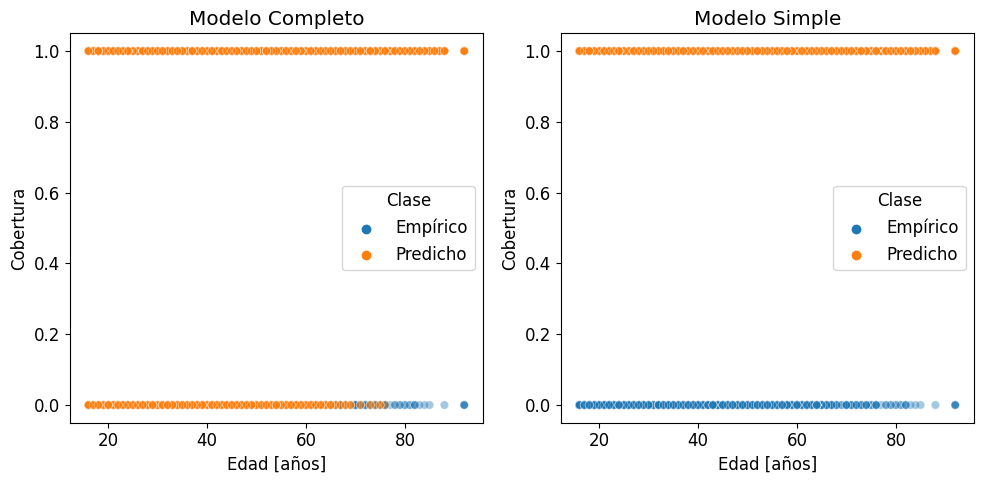

In [ ]:
fig,axes=plt.subplots(1,2)
g1=sns.scatterplot(data=dfComp1,x="age",y="Respuesta",alpha=0.4,hue="Clase",ax=axes[0])
g1.set_xlabel("Edad [años]")
g1.set_ylabel("Cobertura")
g1.set_title("Modelo Completo")
g2=sns.scatterplot(data=dfComp2,x="age",y="Respuesta",alpha=0.4,hue="Clase",ax=axes[1])
g2.set_xlabel("Edad [años]")
g2.set_ylabel("Cobertura")
g2.set_title("Modelo Simple")
fig.tight_layout()
plt.show()

Se ve que en el modelo simple ninguna persona es clasificada como "sin cobertura", por lo que directamente asignó todas las respuestas a la clase mayoritaria con cobertura, sin ningún tipo de distinción.

## Comparación de métricas

Esto se ve con más claridad en las matrices de confusión:


In [ ]:
CMat0=confusion_matrix(y, y_pred0)
dfCM0=pd.DataFrame({"Clas s/SM":CMat0[:,0],"Clas c/SM":CMat0[:,1]},index=["s/SM","c/SM"])
print("Modelo Completo:")
print(dfCM)
print("Modelo Simple:")
print(dfCM0)

Modelo Completo:
      Clas s/SM  Clas c/SM
s/SM       3173      10518
c/SM       1902      59212
Modelo Simple:
      Clas s/SM  Clas c/SM
s/SM          0      13691
c/SM          0      61114


## Comparación de métricas

Más aún, en el `classification_report` se muestran todas las métricas:


In [ ]:
print(classification_report(y, y_pred))
print(classification_report(y, y_pred0))

              precision    recall  f1-score   support

         0.0       0.63      0.23      0.34     13691
         1.0       0.85      0.97      0.91     61114

    accuracy                           0.83     74805
   macro avg       0.74      0.60      0.62     74805
weighted avg       0.81      0.83      0.80     74805

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     13691
         1.0       0.82      1.00      0.90     61114

    accuracy                           0.82     74805
   macro avg       0.41      0.50      0.45     74805
weighted avg       0.67      0.82      0.73     74805



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparación de Curvas ROC

También es notoria la diferencia entre las curvas ROC, donde la curva del modelo simple se agrega en color rojo:


In [ ]:
plt.rcParams['figure.figsize'] = [7.5,7.5]

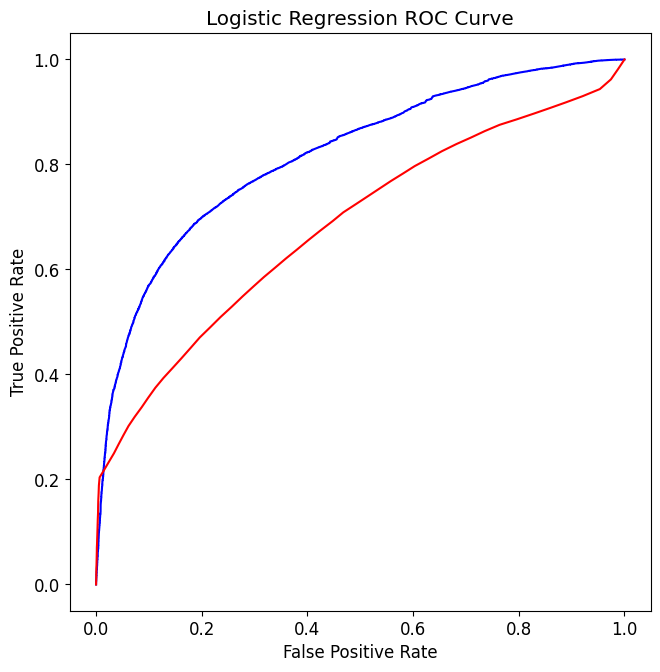

In [ ]:
fpr0, tpr0, thresholds0 = roc_curve(y, y_pred_probs0)
plt.plot(fpr, tpr,c="b")
plt.plot(fpr0, tpr0,c="r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

## Comparación de Áreas bajo la Curva ROC

La diferencia también se expresa en las áreas bajo estas curvas:


In [ ]:
print("Modelo Completo:")
print(roc_auc_score(y, y_pred_probs))
print("Modelo Simple:")
print(roc_auc_score(y, y_pred_probs0))

Modelo Completo:
0.8175553580772248
Modelo Simple:
0.6827424900082738
